In [1]:
import sys
sys.path.append('C:\\Users\\xzhu\\Documents\\GitHub\\trading')

import pandas as pd
import datetime
import math
from pytorch_forecasting import TimeSeriesDataSet

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import TorchNormalizer
from madgrad import MADGRAD

In [2]:
%load_ext autoreload
%autoreload 2

import zenzic.strategies.pytorch.tft.data_processor as dp

In [3]:
SEQ_LEN = 256
PRED_LEN = 32
START_DATE = '2010-01-01'
BATCH_SIZE = 32


In [4]:
prices = dp.sp500_prices(start_date=START_DATE)
date_features = dp.date_features(prices)
prices = prices.join(date_features, on='Date', how='left')

Read prices: 100%|██████████| 498/498 [01:08<00:00,  7.24it/s]


In [5]:
df_train, df_test = dp.split_data(prices, SEQ_LEN, PRED_LEN, 0.7)


In [6]:
train_data = TimeSeriesDataSet(
    df_train,
    time_idx='Date_idx',
    target='Close',
    group_ids=['Symbol'],
    max_encoder_length=SEQ_LEN,
    max_prediction_length=PRED_LEN,
    time_varying_known_reals=[
        'Date_idx',
        'Day_of_year',
        'Day_of_week',
        'Month',
        'Day'],
    time_varying_unknown_reals=[
        'Open',
        'High',
        'Low',
        'Close'
    ],
    target_normalizer=TorchNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=True,
)
test_data = TimeSeriesDataSet.from_dataset(train_data, df_test, predict=False, stop_randomization=True)

train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=0)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=0)

In [7]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    train_data,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer=MADGRAD
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 24.5k


C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

suggested learning rate: 0.011481536214968821


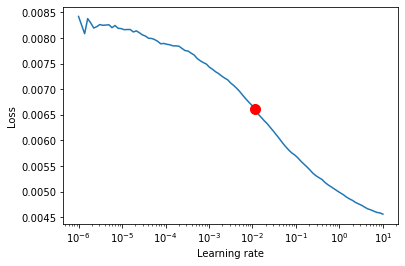

C:\Users\xzhu\AppData\Local\Temp/ipykernel_2264/3771350729.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [8]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=test_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    train_data,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    optimizer=MADGRAD
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 24.5k


In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|█████████▉| 11708/11709 [28:21<00:00,  6.88it/s, loss=0.00375, v_num=3, train_loss_step=0.00356]

C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 1:   1%|          | 90/11709 [00:16<36:07,  5.36it/s, loss=0.00327, v_num=3, train_loss_step=0.00369, val_loss=0.00503, train_loss_epoch=0.0046]   

C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Epoch 1:   1%|          | 91/11709 [00:32<1:09:56,  2.77it/s, loss=0.00327, v_num=3, train_loss_step=0.00369, val_loss=0.00503, train_loss_epoch=0.0046]

In [12]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    test_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    verbose=True,
    optimizer=MADGRAD
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-01-27 08:04:41,059] A new study created in memory with name: no-name-52721de8-e3ae-48fb-90cf-00968de0afb9
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
C:\Users\xzhu\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU c

TypeError: __init__() got an unexpected keyword argument 'logging_level'